In [8]:
import numpy as np
import matplotlib.pyplot as plt
import dftqml.utils
import dftqml.tfmodel
import dftqml.xgb
from os import path
import h5py

import absl.logging
absl.logging.set_verbosity('error')



DFT_CNN_DIR = "./models/dftio/cnn"
RDMFT_CNN_DIR = "./models/rdmftio/cnn"
DATA_DIR = "./data"
N_SPLITS = 5

def history_plot(history_dict):
    plt.plot(history_dict["mse"], label="mse")
    plt.plot(history_dict["val_mse"], label="val_mse")
    plt.xlabel("Epoch")
    plt.ylabel("Loss (mse)")
    plt.grid()
    plt.yscale("log")
    plt.legend()

def dft_cnn_path(L, N, U, ndata, split):
    return path.join(DFT_CNN_DIR, f"L{L}-N{N}-U{U}", f"ndata{ndata}", f"split{split}")

def rdmft_cnn_path(L, N, U, ndata, split):
    return path.join(RDMFT_CNN_DIR, f"L{L}-N{N}-U{U}", f"ndata{ndata}", f"split{split}")

def mse(prediction, exact):
    return np.mean((np.ravel(prediction) - np.ravel(exact)) ** 2)

In [9]:
L = 8
N = 8
U = 4.0
max_ndata = 50000
n_test_data = 1000
input_file = path.join(DATA_DIR, f"L{L}-N{N}-U{U}.hdf5")

with h5py.File(input_file, "r") as f:
    densities = f["densities"][:max_ndata]
    dft_energies = f["dft_energies"][:max_ndata]  # kinetic + interaction energy
    one_rdms = f["one_rdms"][:max_ndata]
    rdmft_energies = f["rdmft_energies"][:max_ndata]

    test_densities = f["densities"][max_ndata : max_ndata + n_test_data]
    test_dft_energies = f["dft_energies"][
        max_ndata : max_ndata + n_test_data
    ]  # kinetic + interaction energy
    test_one_rdms = f["one_rdms"][max_ndata : max_ndata + n_test_data]
    test_rdmft_energies = f["rdmft_energies"][max_ndata : max_ndata + n_test_data]

# transpose RDMs so the locality index is last, as expected by the data augmentation and model
one_rdms = one_rdms.transpose(0, 2, 1)
test_one_rdms = test_one_rdms.transpose(0, 2, 1)

# visualize a single model

### DFT CNN

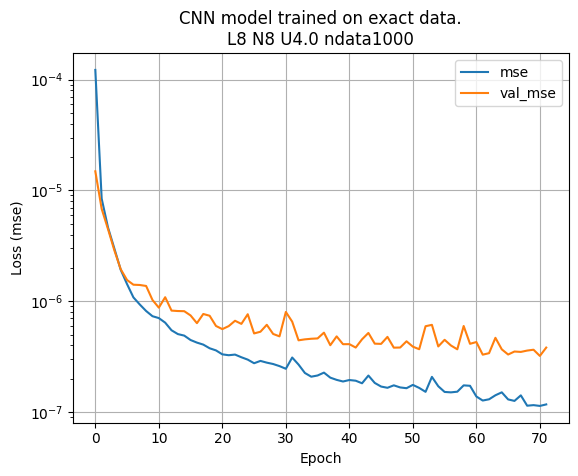

MSE on test set: 2.8718796e-07


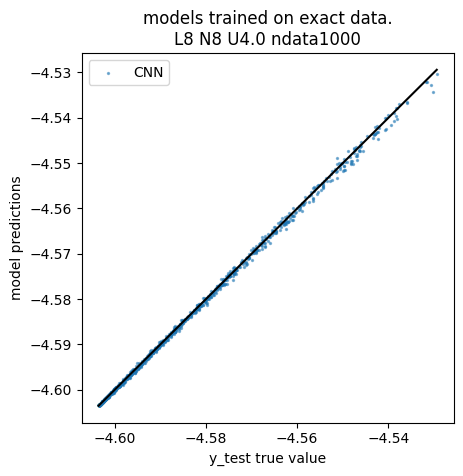

In [6]:
old

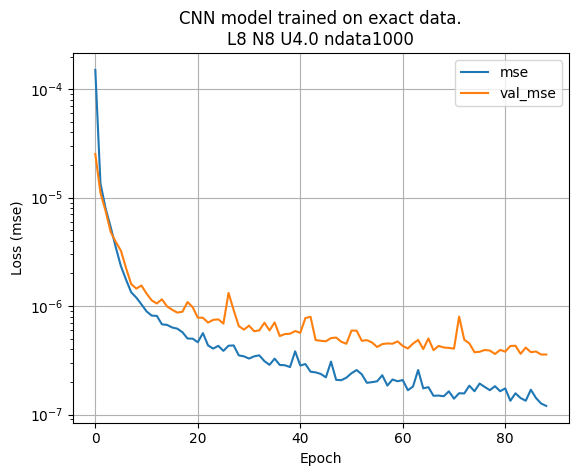

MSE on test set: 3.1057007e-07


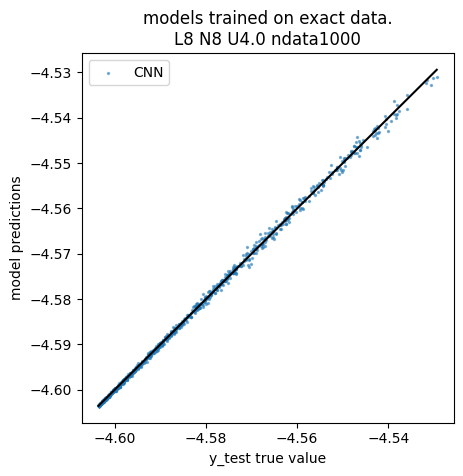

In [10]:
ndata = 1000

# History plot
plt.title("CNN model trained on exact data.\n" f"L{L} N{N} U{U} ndata{ndata}")
model, history_dict = dftqml.tfmodel.load_model(
    dft_cnn_path(L, N, U, ndata, 0), get_history_dict=True
)
history_plot(history_dict)
plt.show()


# Performance plot
plt.figure(figsize=plt.figaspect(1))
plt.title("models trained on exact data.\n" f"L{L} N{N} U{U} ndata{ndata}")
dftqml.utils.performance_plot(model, test_densities, test_dft_energies, label="CNN", s=2, alpha=0.5)
plt.legend()
print("MSE on test set:", mse(model(test_densities), test_dft_energies))

### RDMFT CNN

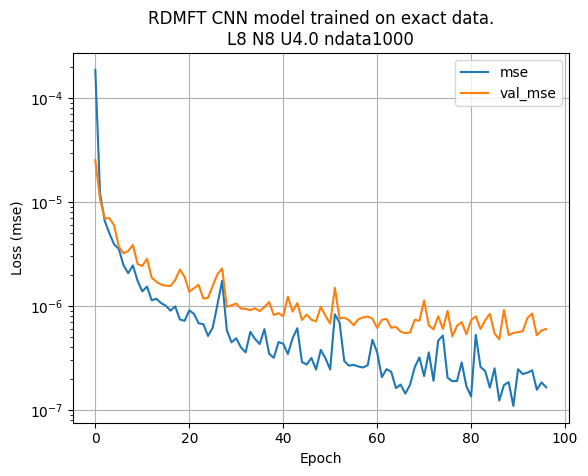

MSE on test set: 5.0402656e-07


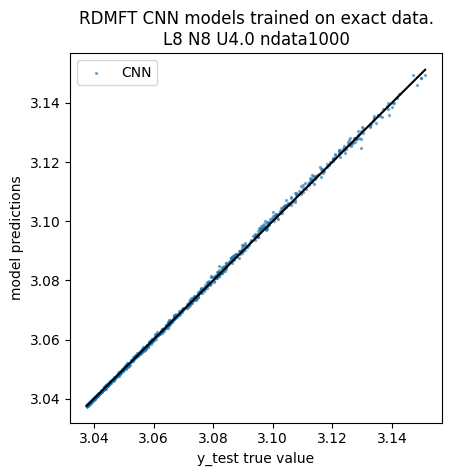

In [11]:
ndata = 1000

# History plot
plt.title("RDMFT CNN model trained on exact data.\n" f"L{L} N{N} U{U} ndata{ndata}")
model, history_dict = dftqml.tfmodel.load_model(
    rdmft_cnn_path(L, N, U, ndata, 0), get_history_dict=True
)
history_plot(history_dict)
plt.show()


# Performance plot
plt.figure(figsize=plt.figaspect(1))
plt.title("RDMFT CNN models trained on exact data.\n" f"L{L} N{N} U{U} ndata{ndata}")
dftqml.utils.performance_plot(model, test_one_rdms, test_rdmft_energies, label="CNN", s=2, alpha=0.5)
plt.legend()
print("MSE on test set:", mse(model(test_one_rdms), test_rdmft_energies))

## MSE scaling with training set size

In [4]:
ndata_list = [100, 200, 500, 1000, 2000, 5000, 10000, 20000, 50000]

def mse_model(ndata, split):
    model = dftqml.tfmodel.load_model(dft_cnn_path(L, N, U, ndata, split), get_history_dict=False)
    return mse(model(test_densities), test_dft_energies)

mse_list = np.array([[mse_model(ndata, split) for split in range(N_SPLITS)]
                     for ndata in ndata_list])

In [ ]:
plt.plot(ndata_list, mse_list, '_k', alpha=0.5)
plt.errorbar(ndata_list, np.mean(mse_list, axis=1), np.std(mse_list, axis=1))

# Fit a linear model to the log-log data
log_ndata = np.log10(ndata_list)
log_mse = np.log10(np.mean(mse_list, axis=1))
coefficients = np.polyfit(log_ndata[:3], log_mse[:3], 1)
poly = np.poly1d(coefficients)
plt.plot(ndata_list, 10**poly(log_ndata), label=f'Fit: slope={coefficients[0]:.2f}', linestyle='--')

plt.xscale("log")
plt.yscale("log")
plt.xlabel("Number of training data")
plt.ylabel("MSE on test set")